In [ ]:
# Session 4 : 09Jul23
# by Sir Nasir
# Chapter # 6 :  Deep learning for text and sequences
# Topic  : 6.1 :  Working with text data

# Text is one of the most widespread forms of sequence data. It can be understood as either a sequence of characters or a sequence of words, but it’s most common to
# work at the level of words.

# Like all other neural networks, deep-learning models don’t take as input raw text: they only work with numeric tensors.
# Vectorizing text is the process of transforming text into numeric tensors. This can be done in multiple ways:
# a) Segment text into words, and transform each word into a vector.
# b) Segment text into characters, and transform each character into a vector.
# c) Extract n-grams of words or characters, and transform each n-gram into a vector. (N-grams are overlapping groups of multiple consecutive words or characters.)


In [1]:
# 6.1.3 Putting it all together: from raw text to word embeddings
# DOWNLOADING THE IMDB DATA AS RAW TEXT
# First, head to http://mng.bz/0tIo and download the raw IMDB dataset. Uncompress it

# Listing 6.8 Processing the labels of the raw IMDB data
import os
imdb_dir = r"E:\PIAIC\AI-Course\Quarter-3\Session-4-09Jul23\aclImdb"
train_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

#print(imdb_dir)
#print(train_dir)
for label_type in ['neg', 'pos']:
 dir_name = os.path.join(train_dir, label_type)
# print("Dir Name : ",dir_name)
 for fname in os.listdir(dir_name):
#   print(fname,label_type)
   if fname[-4:] == '.txt':
     f = open(os.path.join(dir_name, fname),encoding='utf-8')
     texts.append(f.read())
     f.close()
     if label_type == 'neg':
       labels.append(0)
     else:
       labels.append(1)

print("Loop is completed")


Loop is completed


In [2]:
# Listing 6.9 Tokenizing the text of the raw IMDB data
# TOKENIZING THE DATA
# Let’s vectorize the text and prepare a training and validation split, using the concepts introduced earlier in this section. Because pretrained word embeddings are meant to
# be particularly useful on problems where little training data is available (otherwise, task-specific embeddings are likely to outperform them), we’ll add the following twist:
# restricting the training data to the first 200 samples. So you’ll learn to classify movie reviews after looking at just 200 examples.

from keras.preprocessing.text import Tokenizer

# from keras.preprocessing.sequence import pad_sequences   # Not a valid Import statement Replace it with mentioned below statement

from keras.utils import pad_sequences
print(pad_sequences)


import numpy as np

maxlen = 100  # Cuts off reviews after 100 words
training_samples = 200 # Trains on 200 samples
validation_samples = 10000  #  Validates on 10,000 samples
max_words = 10000 # Considers only the top 10,000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(labels)

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

indices = np.arange(data.shape[0]) 
# The above line of code splits the data into a training set and a validation set, but first shuffles the data, because you’re 
# starting with data in which samples are ordered (all negative first, then all positive)

np.random.shuffle(indices)

data = data[indices]
labels = labels[indices]
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

print("Code Processing Completed..")

<function pad_sequences at 0x000001D48C81E8B0>
Found 72633 unique tokens.
Shape of data tensor: (17243, 100)
Shape of label tensor: (17243,)
Code Processing Completed..


In [3]:
# Listing 6.10 Parsing the GloVe word-embeddings file

# PREPROCESSING THE EMBEDDINGS
# Let’s parse the unzipped file (a .txt file) to build an index that maps words (as strings) to their vector representation (as number vectors).

glove_dir = r'E:\PIAIC\AI-Course\Quarter-3\Session-4-09Jul23\glove.6B'

embeddings_index = {}

f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'),encoding='utf-8')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
    
f.close()

print('Found %s word vectors.' % len(embeddings_index))





Found 400000 word vectors.


In [4]:
# Listing 6.11 Preparing the GloVe word-embeddings matrix
# Now, we will build an embedding matrix that you can load into an Embedding layer. It must be a matrix of shape (max_words,
# embedding_dim), where each entry i contains the embedding_dim-dimensional vector for the word of index i in the reference 
# word index (built during tokenization). Note that index 0 isn’t supposed to stand for any word or token—it’s a placeholder.

embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector # Words not found in the embedding index will be all zeros.
            
print("Embedding Matrix")
print(embedding_matrix)

Embedding Matrix
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.038194   -0.24487001  0.72812003 ... -0.1459      0.82779998
   0.27061999]
 [-0.27085999  0.044006   -0.02026    ... -0.4923      0.63687003
   0.23642001]
 ...
 [ 0.44156    -0.11708     0.75514001 ... -1.01660001 -0.005395
  -0.88195997]
 [ 0.58248001  0.096664   -0.033106   ...  1.19930005 -0.056846
  -0.57341999]
 [ 0.41595     0.047901    0.03427    ... -0.24789     0.066317
  -0.19796   ]]


In [5]:
# Listing 6.12 Model definition
# DEFINING A MODEL
# We will use the same model architecture as before.

from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1000000   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 32)                320032    
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [6]:
# Listing 6.13 Loading pretrained word embeddings into the Embedding layer

# LOADING THE GLOVE EMBEDDINGS IN THE MODEL
# The Embedding layer has a single weight matrix: a 2D float matrix where each entry i is the word vector meant to be associated with index i.
# Simple enough. Load the GloVe matrix you prepared into the Embedding layer, the first layer in the model.

model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

# Note : We have freezed the Embedding layer (set its trainable attribute to False), as normally followed in the context of pretrained convnet features: 
# when parts of a model are pretrained (like your Embedding layer) and parts are randomly initialized (like your classifier), 
# the pretrained parts shouldn’t be updated during training, to avoid forgetting what they already know.

print("Loaded Pre Trained Word Embedding")

Loaded Pre Trained Word Embedding


In [7]:
# Listing 6.14 Training and evaluation
# Lets Compile and train the model.

model.compile(optimizer='rmsprop',
loss='binary_crossentropy',
metrics=['acc'])

history = model.fit(x_train, y_train,
epochs=10,
batch_size=32,
validation_data=(x_val, y_val))

model.save_weights('pre_trained_glove_model.h5')

print("Model Weights are saved")

Epoch 1/10
7/7 [==============================] - 8s 1s/step - loss: 1.4291 - acc: 0.6550 - val_loss: 0.5891 - val_acc: 0.7219
Epoch 2/10
7/7 [==============================] - 12s 2s/step - loss: 0.5053 - acc: 0.7350 - val_loss: 0.5999 - val_acc: 0.7220
Epoch 3/10
7/7 [==============================] - 6s 1s/step - loss: 0.3971 - acc: 0.7800 - val_loss: 0.6301 - val_acc: 0.7194
Epoch 4/10
7/7 [==============================] - 9s 1s/step - loss: 0.3869 - acc: 0.8200 - val_loss: 0.6146 - val_acc: 0.7219
Epoch 5/10
7/7 [==============================] - 7s 1s/step - loss: 0.2578 - acc: 0.8450 - val_loss: 1.4869 - val_acc: 0.2887
Epoch 6/10
7/7 [==============================] - 11s 2s/step - loss: 0.3817 - acc: 0.8650 - val_loss: 1.0653 - val_acc: 0.7218
Epoch 7/10
7/7 [==============================] - 10s 2s/step - loss: 0.1120 - acc: 0.9700 - val_loss: 0.7397 - val_acc: 0.7201
Epoch 8/10
7/7 [==============================] - 8s 1s/step - loss: 0.0541 - acc: 0.9950 - val_loss: 0.8537

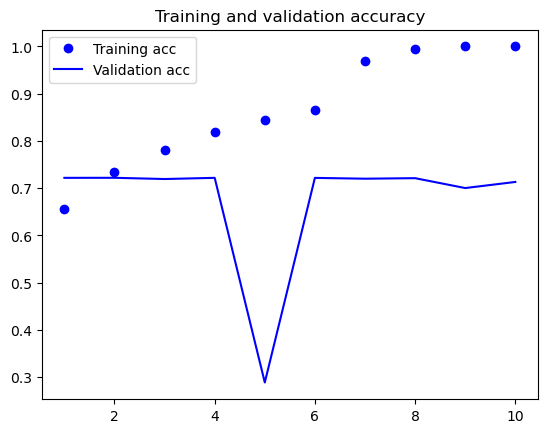

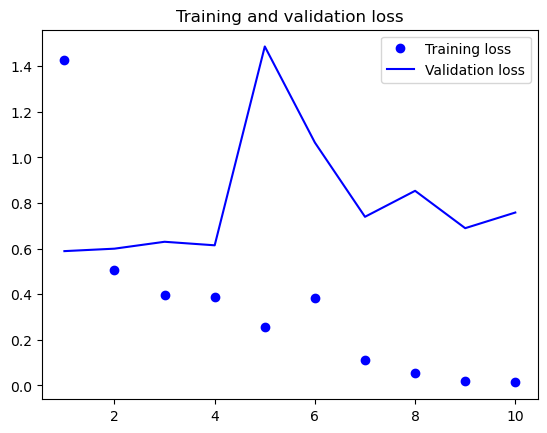

In [8]:
# Listing 6.15 Plotting the results

#model.load_weights("pre_trained_glove_model.h5")

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import matplotlib.pyplot as plt

acc = history.history['acc']

val_acc = history.history['val_acc']

loss = history.history['loss']

val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')

plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.legend()
plt.show()

In [ ]:
# The model quickly starts overfitting, which is unsurprising given the small number of training samples. Validation accuracy 
# has high variance for the same reason, but it seems to reach the high 50s.

# You can also train the same model without loading the pretrained word embeddings and without freezing the embedding layer.
# Validation accuracy stalls in the low 50s. So in this case, pretrained word embeddings outperform jointly learned embeddings.
# If you increase the number of training samples, this will quickly stop being the case—try it as an exercise.

In [9]:
# Listing 6.17 Tokenizing the data of the test set
# Let’s evaluate the model on the test data. First, you need to tokenize the test data.
import os 

imdb_dir = r"E:\PIAIC\AI-Course\Quarter-3\Session-4-09Jul23\aclImdb"
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname),encoding='utf-8')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)
                
                
sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)


# Now load and evaluate the first model.
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)



539/539 [==============================] - 20s 36ms/step - loss: 0.7366 - acc: 0.7204


[0.7366183400154114, 0.7203502655029297]

In [ ]:
# 6.1.4 Wrapping up
# Now you’re able to do the following:
#  >> Turn raw text into something a neural network can process
#  >> Use the Embedding layer in a Keras model to learn task-specific token embeddings
#  >> Use pretrained word embeddings to get an extra boost on small naturallanguage processing problems